# Oblique Schmidt Method
Implement extrapolator that uses oblique schmidt method

In [49]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import astropy.units as u
import astropy.coordinates
import sunpy.map
import sunpy.net
import sunpy.time
import sunpy.coordinates
import solarbextrapolation.extrapolators
import synthesizAR

%matplotlib inline

In [31]:
result_aia = sunpy.net.Fido.search(
    sunpy.net.attrs.Time(sunpy.time.TimeRange('2017/08/22 18:15',1*u.min)),
    sunpy.net.attrs.Instrument('AIA'),
    sunpy.net.attrs.Wavelength(171*u.angstrom)
)

In [ ]:
result_hmi = sunpy.net.Fido.search(
    sunpy.net.attrs.Time(sunpy.time.TimeRange('2017/08/22 18:15',1*u.min)),
    sunpy.net.attrs.Instrument('HMI') & sunpy.net.attrs.vso.Physobs('LOS_magnetic_field'),
)

In [33]:
aia_files = sunpy.net.Fido.fetch(result_aia)

[                                        ========================================


In [ ]:
hmi_files = sunpy.net.Fido.fetch(result_hmi)

In [2]:
hmi_files = ['/Users/willbarnes/sunpy/data/hmi_m_45s_2017_08_22_18_16_30_tai_magnetogram.fits']

In [3]:
m = sunpy.map.Map(hmi_files[0])

In [4]:
lc = (150*u.arcsec,-200*u.arcsec)
rc = (700*u.arcsec,350*u.arcsec)
bottom_left = astropy.coordinates.SkyCoord(*lc,frame=m.coordinate_frame)
top_right = astropy.coordinates.SkyCoord(*rc,frame=m.coordinate_frame)

In [5]:
m_zoom = m.rotate().submap(bottom_left,top_right)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


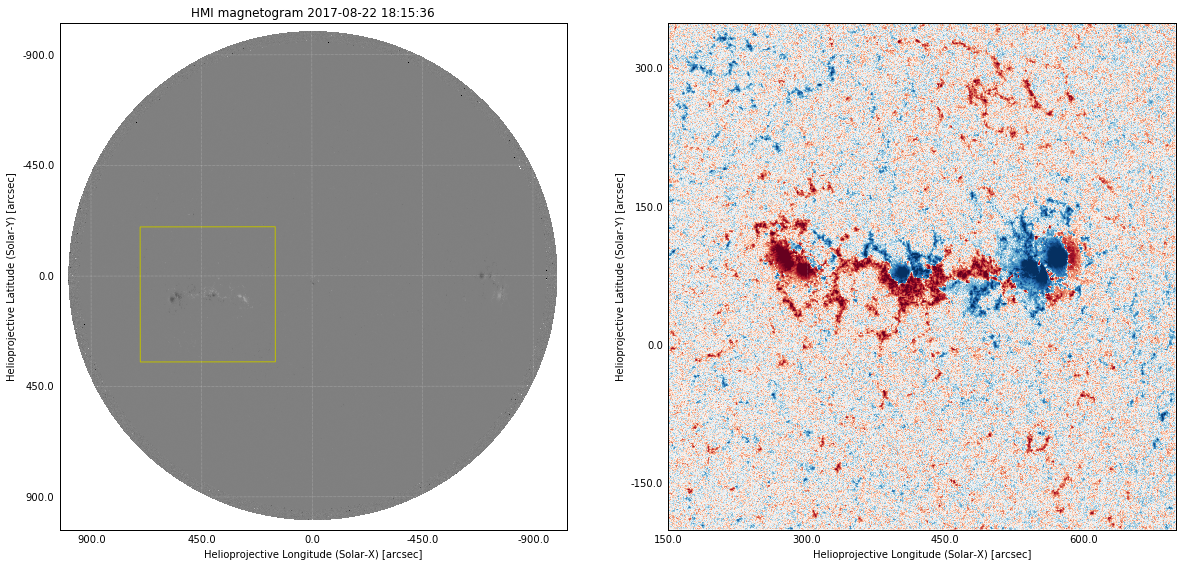

In [10]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121,projection=m)
m.plot(axes=ax)
m.draw_rectangle(bottom_left,rc[0]-lc[0],rc[1]-lc[1],color='y')
ax = fig.add_subplot(122,projection=m_zoom)
im = m_zoom.plot(axes=ax,title=False,
                 norm=matplotlib.colors.SymLogNorm(10,vmin=-500,vmax=500),
                 cmap=plt.get_cmap('RdBu_r'))
#fig.colorbar(im)

## Classical Schmidt Method

In [7]:
zshape = 100
zrange = u.Quantity([0*u.arcsec,max(rc[0]-lc[0],rc[1]-lc[1])])

In [8]:
classical_field = synthesizAR.Skeleton(hmi_fits_file=hmi_files[0],crop=(lc,rc),resample=[100,100]*u.pixel)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [11]:
classical_field.extrapolate_field(zshape=zshape,zrange=zrange)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation-0.1.dev151-py3.5.egg/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation-0.1.dev151-py3.5.egg/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation-0.1.dev151-py3.5.egg/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/

True


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev470-py3.5.egg/synthesizAR/field.py:190: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev470-py3.5.egg/synthesizAR/field.py:191: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev470-py3.5.egg/synthesizAR/field.py:198: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi_map.xrange).value,
/Users/willbarnes/anaconda/envs/synthesizar/lib/p

In [29]:
classical_field.extract_streamlines(500,mask_threshold=0.1,safety=1.5)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev470-py3.5.egg/synthesizAR/util/util.py:69: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_x = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.xrange)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev470-py3.5.egg/synthesizAR/util/util.py:70: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_y = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.yrange)
yt : [INFO     ] 2017-10-27 14:29:40,220 AMRKDTree rebuilt, Final Volume: 5.843842e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 761.56it/s]
yt : [INFO     ] 2017-10-27 14:29:41,661 AMRKDTree rebuilt, Final Volume: 5.843842e+31
Streamlining: 100%|██████████| 134/134 [00:00<00:00, 714.42it/s]
yt : [INFO     ] 2017-10-27 14:29:42,273 AMRKDTree rebuilt, Final Volume: 5.843842e+31
Streamlinin

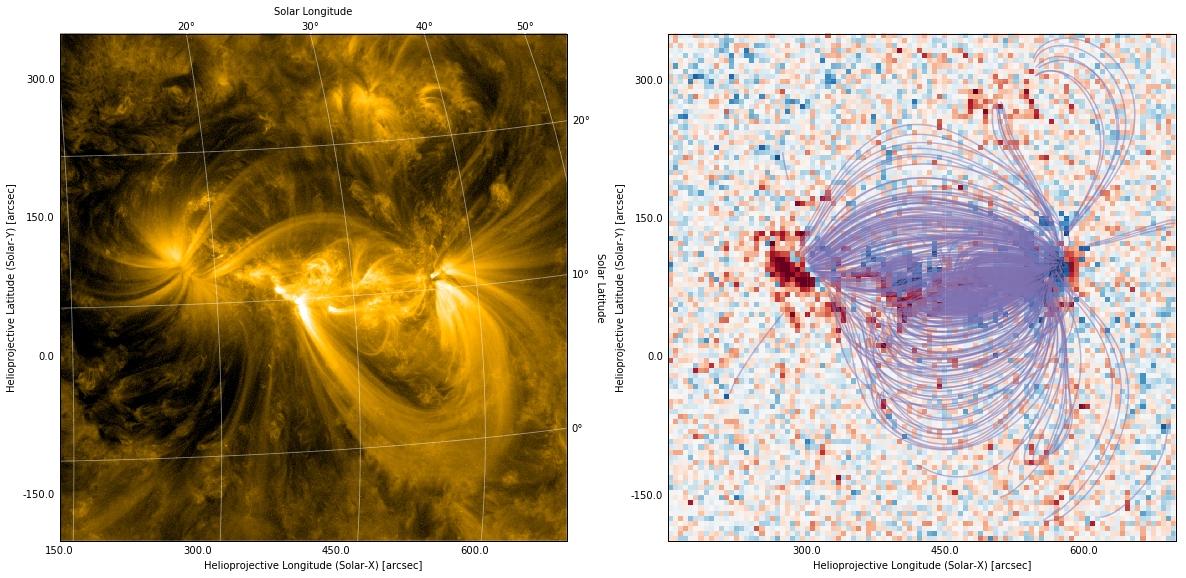

In [75]:
fig = plt.figure(figsize=(20,10))
aia_m = sunpy.map.Map(aia_files[-1])
aia_m = aia_m.submap(astropy.coordinates.SkyCoord(*lc,frame=aia_m.coordinate_frame),
                     astropy.coordinates.SkyCoord(*rc,frame=aia_m.coordinate_frame))
ax = fig.add_subplot(121,projection=aia_m)
aia_m.plot(axes=ax,title=False,norm=matplotlib.colors.LogNorm(vmin=50,vmax=5e3))
aia_m.draw_grid(axes=ax,grid_spacing=10*u.deg)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax = fig.add_subplot(122,projection=classical_field.hmi_map)
im = classical_field.hmi_map.plot(axes=ax,title=False,
                 norm=matplotlib.colors.SymLogNorm(10,vmin=-500,vmax=500),
                 cmap=plt.get_cmap('RdBu_r'))
for stream, _ in classical_field.streamlines:
    ax.plot(classical_field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
            classical_field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
            alpha=0.5,color=sns.color_palette('deep')[3],transform=ax.get_transform('world'))

Because the AR is far from disk center, the classical Schmidt approximation does not do well. A cursory comparison reveals that the field extrapolation at the right does not capture the correct orientation of the loops.

## Oblique Schmidt Method
Section 3 of Sakurai (1982) outlines the oblique Schmidt method. The potential now is given by,

$$
\phi(\vec{r}) = \int\mathrm{d}S\,B_{\ell}(\vec{r}^{'})G_{\ell}(\vec{r},\vec{r}^{'}) \approx \sum_{ij}B_{\ell}(r_{ij})G_{\ell}(r,r_{ij})S_{ij},
$$

where $B_l$ is the observed field at the boundary which satisfies the condition 

$$
-\hat{\ell}\cdot\nabla\phi=B_{\ell},
$$
$\hat{\ell}$ is the vector from the AR to observer and the Green's function for the problem can be written as,

$$
G_{\ell}(\vec{r},\vec{r}^{'}) = \frac{1}{2\pi}\left(\frac{\hat{n}\cdot\hat{\ell}}{R} + \frac{\hat{\mu}\cdot\vec{R}}{R(R+\hat{\ell}\cdot\vec{R})}\right)
$$

where $\hat{n}$ is the vector perpendicular to the surface of the Sun, $\vec{R}=\vec{r}-\vec{r}^{'}$ and $\hat{\mu}=\hat{\ell}\times(\hat{n}\times\hat{\ell})$

We can treat $\ell=\hat{z}=(0,0,1)$ as it is the vector pointing from us to the AR. The problem then is to find $\hat{n}$, the vector normal to the boundary.

This is easily accomplished by converting to the HeliographicStonyhurst frame, in Cartesian (HEEQ) coordinates, and then rotating $\pi/2$ about the y-axis such that the z-axis of the extrapolated field is parallel to $\hat{\ell}$

In [65]:
m.coordinate_frame

<Helioprojective Frame (obstime=2017-08-22 18:15:36, rsun=696000000.0 m, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-22 18:15:36): (lon, lat, radius) in (deg, deg, m)
    ( 0.,  6.9596,   1.51252087e+11)>)>

In [66]:
center_hgs = m_zoom.center.transform_to(sunpy.coordinates.frames.HeliographicStonyhurst)

In [67]:
x = np.cos(center_hgs.T.lat)*np.cos(center_hgs.T.lon)
y = np.cos(center_hgs.T.lat)*np.sin(center_hgs.T.lon)
z = np.sin(center_hgs.T.lat)

In [73]:
print(x,y,z)

0.8753439412285449 0.4461007030354235 0.18645950580696774


In [68]:
np.sqrt(x**2+y**2+z**2)

<Quantity 1.0>

In [71]:
n_perp = np.array([[0,0,1],[0,1,0],[-1,0,0]]) @ np.array([x.value,y.value,z.value])

In [72]:
n_perp

array([ 0.18645951,  0.4461007 , -0.87534394])

Now in this new frame, note that $\hat{\ell}=(0,0,1)$. Note also that because $\vec{R}$ is defined as the difference between the boundary location and $\vec{r}$, we can use any coordinate system we'd like.

In [ ]:
class ObliqueExtrapolator(object):
    
    def __init__(self,hmi_map,zshape,zrange):
        self.hmi_map = hmi_map
        self.zshape = zshape
        self.zrange = zrange
    
    def calculate_phi(self):
        pass
    
    def calculate_field(self):
        ## take gradient of phi to get Bx,By,Bz
        pass
    
    def extrapolate(self,**kwargs):
        pass